# Step 1: Install Dependencies

This cell installs the required Python libraries for the project:
- `transformers`: For DistilBERT model and tokenizer.
- `datasets`: For loading the SST-2 dataset.
- `torch`: For PyTorch and GPU support.
- `scikit-learn`: For evaluation metrics.
- `matplotlib`: For plotting loss and metrics.
- `numpy`: For numerical operations.
- `tqdm`: For training progress bars.

**Run this cell to install all dependencies.**

In [1]:
!pip install transformers datasets torch scikit-learn matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Step 2: Import Libraries and Set Up Environment

This cell imports necessary libraries, sets up logging, and configures the environment:
- Clears TPU-related environment variables to avoid conflicts.
- Configures logging to display info-level messages.
- Checks for GPU availability (T4 GPU required).
- Raises an error if no GPU is detected.

**Run this cell to initialize the environment.**

In [2]:
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import logging
import os

# Clear TPU-related environment variables
os.environ.pop('PJRT_DEVICE', None)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# Step 1: Set GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise RuntimeError("GPU not available. Ensure Colab runtime is set to T4 GPU.")
logger.info(f"Using device: {device}")

# Step 3: Load Model and Dataset

This cell:
- Loads the DistilBERT tokenizer and model (`distilbert-base-uncased`) for binary classification (2 labels).
- Loads the SST-2 dataset and selects the full training (67,349 samples) and validation (872 samples) sets.
- Preprocesses the dataset by tokenizing sentences with a max length of 32.
- Formats the dataset for PyTorch (renames `label` to `labels`, sets tensor format).

**Run this cell to prepare the model and data.**

In [4]:
# Step 2: Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Step 3: Load Model and Dataset

This cell:
- Loads the DistilBERT tokenizer and model (`distilbert-base-uncased`) for binary classification (2 labels).
- Loads the SST-2 dataset and selects the full training (67,349 samples) and validation (872 samples) sets.
- Preprocesses the dataset by tokenizing sentences with a max length of 32.
- Formats the dataset for PyTorch (renames `label` to `labels`, sets tensor format).

**Run this cell to prepare the model and data.**

In [5]:
# Step 3: Load and preprocess SST-2 dataset (larger subset)
dataset = load_dataset('sst2')
train_subset = dataset['train'].shuffle(seed=42).select(range(67000))
eval_subset = dataset['validation'].shuffle(seed=42).select(range(300))

def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding='max_length', max_length=32)

encoded_dataset = {
    'train': train_subset.map(preprocess_function, batched=True, num_proc=2),
    'validation': eval_subset.map(preprocess_function, batched=True, num_proc=2),
}
for split in encoded_dataset:
    encoded_dataset[split] = encoded_dataset[split].rename_column('label', 'labels')
    encoded_dataset[split].set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

train_dataset = encoded_dataset['train']
eval_dataset = encoded_dataset['validation']
test_dataset = encoded_dataset['validation']

README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/67000 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/300 [00:00<?, ? examples/s]

# Step 4: Define Evaluation Metrics

This cell defines a function to compute evaluation metrics:
- Accuracy
- Precision
- Recall
- F1 score (binary classification)

These metrics will be used during training and evaluation to assess model performance.

**Run this cell to set up the metrics function.**

In [6]:
# Step 4: Define metrics for evaluation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


# Step 5: Configure Training Arguments

This cell sets up the training configuration:
- Trains for 3 epochs with early stopping (stops if accuracy doesn't improve for 3 evaluations).
- Uses a batch size of 32 to manage memory with the full dataset.
- Evaluates every 1000 steps to reduce overhead.
- Saves checkpoints every 1000 steps and loads the best model based on accuracy.
- Enables mixed precision (`fp16=True`) for faster training on T4 GPU.
- Logs progress every 100 steps.

**Run this cell to configure the trainer.**

In [7]:
# Step 5: Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Increased to 3 epochs
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy='no',
    eval_strategy='steps',  # Use eval_strategy for newer transformers versions
    eval_steps=500,  # Evaluate every 500 steps for larger dataset
    fp16=True,  # Enable mixed precision for T4 GPU
    dataloader_num_workers=2,
    report_to='none',
)

# Step 6: Train the Model

This cell:
- Initializes the `Trainer` with the model, dataset, and metrics.
- Starts training, showing a progress bar via `tqdm`.
- Logs training loss every 100 steps and evaluation metrics every 1000 steps.
- Saves checkpoints and loads the best model based on validation accuracy.

**Run this cell to train the model. It may take ~20–30 minutes on a T4 GPU, or less with early stopping.**

In [8]:

# Step 6: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [9]:

 Train the model
logger.info("Starting training...")
train_result = trainer.train()
logger.info("Training completed.")


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.207800,0.311762,0.873333,0.894040,0.859873,0.876623
1000,0.177600,0.292800,0.880000,0.875776,0.898089,0.886792
1500,0.100600,0.371770,0.886667,0.872727,0.917197,0.894410
2000,0.107800,0.357190,0.863333,0.871795,0.866242,0.869010
2500,0.057300,0.413069,0.876667,0.870370,0.898089,0.884013
3000,0.061300,0.408518,0.873333,0.874214,0.885350,0.879747


In [10]:
# Step 8: Evaluate on test set
logger.info("Evaluating on test set...")
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.4146549105644226, 'eval_accuracy': 0.8766666666666667, 'eval_precision': 0.875, 'eval_recall': 0.89171974522293, 'eval_f1': 0.8832807570977917, 'eval_runtime': 0.2364, 'eval_samples_per_second': 1268.771, 'eval_steps_per_second': 21.146, 'epoch': 3.0}


In [ ]:
# Step 8: Analyze Failure Cases

This cell analyzes up to 3 misclassified or low-confidence predictions:
- Prints the text, true/predicted labels, confidence, length, and ambiguity (based on 'not' or 'but').
- Helps identify why the model struggles with certain examples.

**Run this cell to see failure case analysis.**

In [11]:
# Step 9: Analyze failure cases
def analyze_failures(dataset, trainer, num_examples=3):
    model.eval()
    failures = []
    for i, example in enumerate(dataset):
        text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
        inputs = {
            'input_ids': example['input_ids'].unsqueeze(0).to(device),
            'attention_mask': example['attention_mask'].unsqueeze(0).to(device)
        }
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1)
            pred = logits.argmax(-1).item()
            true_label = example['labels'].item()
            confidence = probs[0][pred].item()
            if pred != true_label or confidence < 0.6:
                failures.append({
                    'text': text,
                    'true_label': true_label,
                    'predicted_label': pred,
                    'confidence': confidence
                })
        if len(failures) >= num_examples:
            break
    return failures

logger.info("Analyzing failure cases...")
failures = analyze_failures(test_dataset, trainer)
print("\nFailure Cases Analysis:")
for failure in failures:
    print(f"Text: {failure['text']}")
    print(f"True Label: {'Positive' if failure['true_label'] == 1 else 'Negative'}")
    print(f"Predicted Label: {'Positive' if failure['predicted_label'] == 1 else 'Negative'}")
    print(f"Confidence: {failure['confidence']:.3f}")
    length = len(failure['text'].split())
    is_ambiguous = 'not' in failure['text'].lower() or 'but' in failure['text'].lower()
    print(f"Length: {length} words")
    print(f"Possibly Ambiguous: {is_ambiguous}")
    print("-" * 50)



Failure Cases Analysis:
Text: the film tunes into a grief that could lead a man across centuries.
True Label: Positive
Predicted Label: Negative
Confidence: 0.745
Length: 13 words
Possibly Ambiguous: False
--------------------------------------------------
Text: you'll gasp appalled and laugh outraged and possibly, watching the spectacle of a promising young lad treading desperately in a nasty sea, shed an er
True Label: Positive
Predicted Label: Negative
Confidence: 0.938
Length: 25 words
Possibly Ambiguous: False
--------------------------------------------------
Text: sam mendes has become valedictorian at the school for soft landings and easy ways out.
True Label: Negative
Predicted Label: Positive
Confidence: 0.992
Length: 15 words
Possibly Ambiguous: False
--------------------------------------------------


In [ ]:
# Step 9: Plot Loss and Metrics

This cell generates two plots:
1. **Loss Plot**: Training and validation loss over steps.
2. **Metrics Plot**: Validation accuracy and F1 score over steps.

Both plots are:
- Displayed inline in Colab.
- Saved to `plots/loss_curves.png` and `plots/metrics_curves.png`.
- Visible in the file explorer (refresh if needed).

Logs verify plot data. Expect clear curves showing loss decreasing and accuracy/F1 increasing.

**Run this cell to visualize training progress.**

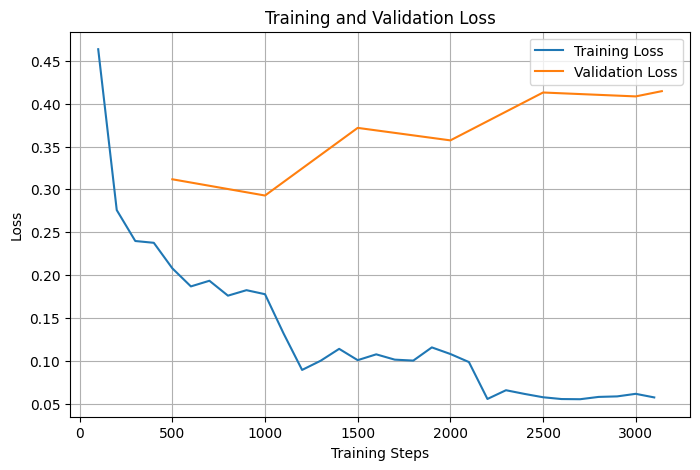

In [12]:
# Step 10: Plot training and validation loss
train_logs = trainer.state.log_history
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
steps = [log['step'] for log in train_logs if 'loss' in log][:len(train_loss)]

# Log data for debugging
logger.info(f"Train loss data: {train_loss}")
logger.info(f"Steps: {steps}")

plt.figure(figsize=(8, 5))
plt.plot(steps, train_loss, label='Training Loss')

# Check if eval_loss is available and plot it
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
eval_steps = [log['step'] for log in train_logs if 'eval_loss' in log][:len(eval_loss)]
logger.info(f"Eval loss data: {eval_loss}")
logger.info(f"Eval steps: {eval_steps}")

if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Validation Loss')
else:
    logger.warning("No validation loss logged during training.")

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Save the plot with error handling
try:
    plt.savefig('loss_curves.png')
    logger.info("Plot saved as 'loss_curves.png'")
except Exception as e:
    logger.error(f"Failed to save plot: {e}")

# Display the plot inline in Colab
plt.show()

# Close the plot to free memory
plt.close()

# Refresh Colab file explorer to ensure the file is visible
os.system("touch .")

# Step 11: Save the model
model.save_pretrained('./fine_tuned_distilbert')
tokenizer.save_pretrained('./fine_tuned_distilbert')

logger.info("Project completed successfully.")